# Моделька для Wannait

## Постановка задачи
Необходимо разработать модель с алгоритмом рекомендаций, которая удовлетворяет критериям:
* можно реализовать на бекенд-сервере (он не может быть слишком сложным для вычисления)
* можно обновлять рекомендации за разумное время (15 минут)
* можно относительно быстро найти объекты с наибольшим предсказанием

## Идея текущего решения (модели):
* Модель из 2 матриц, заполненных спецпараметром лямбда = sqrt(ср. арифм. (rating) / N)  
Обоснование лябмды  
    Доказать, что lambda даст минимальный MSE на старте  
    Цель: найти l
    Условие:
        способ оценки - MSE
        MSE >= 0 -> min MSE == 0
        модель - константа l
    Решение:
        Вариант 1
        sum((l - x) ** 2) / N -> min
        MSE'l = sum((l - x) ** 2 / N)' = sum(2(l - x) / N) = 0
        sum(l - x) = 0
        тк sum - конечный ряд, то
        sum(x) - l * N = 0
        l = sum(x) / N
        
        Вариант 2
        У MSE и у l растут из одного и того же места ноги (из задачи maximal likehood)
        ==> решение задачи, если данные распределены по Пуассону:
            l = sum(x) / N
    
    Цель: найти lambda  
    Условие:
        l = [lambda for i in range(n_factors)] * [lambda for i in range(n_factors)].T
    Решение:
        l = n_factors * lambda ^ 2
        lambda = sqrt(l / n_factors)
        ЧТД
        
* Предсказание - скалярное перемножение векторов факторов пользователей и продуктов
## Идеи:
* использовать доп данные и свести к решению задачи бинарной классификации (лайк / дизлайк)
(фичи: результат коллаборативной фильтрации, данные о фильме, данные о пользователе)
* использовать ансамбли из дешёвых алгоритмов

## Импорты и настроечки

In [13]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import scipy
import torch
import matplotlib.pyplot as plt
import math

basepath = 'the-movies-dataset/'
# количество записей из таблички
PART = 100000 # количество данных, взятых из csv
epochs = 50 #количество эпох обучения
epoch_part = 1000 # количество кортежей (пользователь, продукт, оценка), используемое за эпоху
n_factors = 20 # количество строк (столбцов) в матрицах факторов
test_split = 1000 # количество кортежей (пользователь, продукт, оценка), используемое для тестирования

## Анализ и Обработка данных

In [14]:
# берём часть данных о рейтингах (для полного охвата нужно >330 GB, что невозможно на обычной машине)
ratings_df = pd.read_csv(basepath + 'ratings.csv').iloc[:PART, :]

In [15]:
# нормализуем (наивно) рейтинг
ratings_df['rating'] = ratings_df['rating'] / 5

In [16]:
# среднее число оценок на пользователя
ratings_df.groupby('userId').count().mean()

movieId      98.619329
rating       98.619329
timestamp    98.619329
dtype: float64

In [17]:
lambda_parameter = math.sqrt(ratings_df['rating'].mean() / n_factors)

lambda_parameter

0.18779669858653

In [18]:
# число пользователей и продуктов
n_users, n_products = ratings_df.loc[:,['userId', 'movieId']].nunique()
n_users, n_products

(1014, 8832)

In [19]:
# формируем матричку для Факторизации
ratings_pivot_df = ratings_df.pivot(index='userId', columns='movieId', values='rating')
ratings_pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,173209,173291,173353,174055,174231,174393,174585,174843,175579,176271
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
ratings = ratings_pivot_df.as_matrix()
indexes = np.where(~np.isnan(ratings))

/home/ls/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [21]:
order = np.arange(len(indexes[0]))
np.random.shuffle(order)
indexes = (indexes[0][order], indexes[1][order])
test_indexes = (indexes[0][:test_split], indexes[1][:test_split])
indexes = (indexes[0][test_split:], indexes[1][test_split:])
indexes

(array([ 64, 272, 877, ..., 740, 740, 835]),
 array([2064, 4673, 7416, ..., 1113, 3877, 2618]))

## Машинное обучение

## В качестве baseline используем SVD

In [22]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_products, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Parameter(torch.full((n_users, n_factors), lambda_parameter, dtype=torch.float32),
                                               requires_grad=True)
        self.product_factors = torch.nn.Parameter(torch.full((n_factors, n_products), lambda_parameter, dtype=torch.float32),
                                               requires_grad=True)

    def forward(self, user, product):
        return torch.mm(self.user_factors[user, :],
                        self.product_factors[:, product])
    
    def predict(self, user, product):
        return self.forward(user, product)
    
    def predict_all(self) -> torch.Tensor:
        return torch.mm(self.user_factors, self.product_factors)
    
model = MatrixFactorization(n_users, n_products, n_factors=n_factors)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("using device {}".format(device))
print("model parameters:")
for parameter in model.parameters():
    print(parameter)
    print(parameter.shape)

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                            lr=1e-3)


using device cuda:0
model parameters:
Parameter containing:
tensor([[0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        ...,
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878]],
       device='cuda:0', requires_grad=True)
torch.Size([1014, 20])
Parameter containing:
tensor([[0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        ...,
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878],
        [0.1878, 0.1878, 0.1878,  ..., 0.1878, 0.1878, 0.1878]],
       device='cuda:0', requires_grad=True)
torch.Size(

In [23]:
def train():
    train_loss_history = []
    val_loss_history = []
    phases = ['train', 'val']
    
    for epoch in range(epochs):
        print('\n\nEpoch {} / {}'.format(epoch, epochs))
        # shuffle data
        order = np.arange(len(indexes[0]))
        np.random.shuffle(order)
        train_order = order[:epoch_part]
        val_order = order[epoch_part:2 * epoch_part]
        
        for phase in phases:
            if phase == 'train':
                optimizer.zero_grad()
                current_order = train_order
                current_indexes = (indexes[0][train_order], indexes[1][train_order])
                history = train_loss_history
            else:
                current_order = val_order
                current_indexes = (indexes[0][val_order], indexes[1][val_order])
                history = val_loss_history

            rating = ratings[current_indexes[0], :][:, current_indexes[1]]
            prediction = model.predict(current_indexes[0], current_indexes[1]).to(device)
            # form mask array
            mask = torch.zeros(rating.shape)
            normal_poses = np.where(~np.isnan(rating))
            for pose in zip(normal_poses[0], normal_poses[1]):
                mask[pose[0], pose[1]] = 1
            rating = np.nan_to_num(rating)
            rating = torch.tensor(rating, dtype=torch.float32, device=device)
            mask = mask.to(device)

            rating *= mask
            prediction *= mask

            loss = loss_func(prediction, rating)
            running_loss = loss.data.cpu()
            print('{} loss {}'.format(phase, running_loss))
            history.append(running_loss)
            if phase == 'train':
                loss.backward()
                
                optimizer.step()
        
    return train_loss_history, val_loss_history

In [24]:
history = train()



Epoch 0 / 50
train loss 0.007722136564552784
val loss 0.00791983399540186


Epoch 1 / 50
train loss 0.007995340041816235
val loss 0.007522765547037125


Epoch 2 / 50
train loss 0.007843675091862679
val loss 0.007626995909959078


Epoch 3 / 50
train loss 0.007112433668226004
val loss 0.00733239995315671


Epoch 4 / 50
train loss 0.007285361178219318
val loss 0.007524856366217136


Epoch 5 / 50
train loss 0.007262481842190027
val loss 0.007518996484577656


Epoch 6 / 50
train loss 0.007249865215271711
val loss 0.007170319557189941


Epoch 7 / 50
train loss 0.006905980873852968
val loss 0.006763985846191645


Epoch 8 / 50
train loss 0.006947500631213188
val loss 0.006613616365939379


Epoch 9 / 50
train loss 0.006744941230863333
val loss 0.006455684080719948


Epoch 10 / 50
train loss 0.006553052458912134
val loss 0.006735005881637335


Epoch 11 / 50
train loss 0.006884973030537367
val loss 0.006693677511066198


Epoch 12 / 50
train loss 0.006762245669960976
val loss 0.00652963947504758

# Визуализация результатов обучения

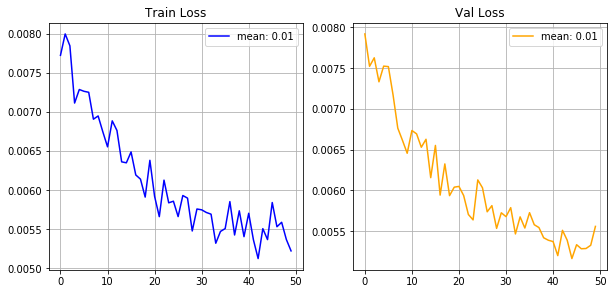

In [25]:
titles = ['Train Loss', 'Val Loss']
plt.figure(figsize=(10, 10))
for i, values in enumerate(history):
    plt.subplot(2, 2, i+1)
    plt.title(titles[i])
    plt.grid()
    if i == 0:
        color = 'b'
    else:
        color = 'orange'
    plt.plot(values,c=color, label= 'mean: %.2f' % np.array(values).mean())
    plt.legend(loc='best')
plt.show()

# Тестирование результатов

In [26]:
rating = torch.tensor(ratings[test_indexes[0], :][:, test_indexes[1]], dtype=torch.float32)
prediction = model.predict(test_indexes[0], test_indexes[1]).to(device)
# form mask array
mask = torch.ones(rating.shape)
nan_poses = np.where(np.isnan(rating))
for pose in zip(nan_poses[0], nan_poses[1]):
    mask[pose[0], pose[1]] = 0
    rating[pose[0], pose[1]] = 0
rating = rating.to(device)
mask = mask.to(device)

rating *= mask
prediction *= mask

loss = loss_func(prediction, rating)
test_loss = loss.data.cpu()
print('Test loss {}'.format(test_loss))

Test loss 0.00512629933655262


In [27]:
print('СКО (по смещенной дисперсии (у Netflix в 2010 0.8554 для rating [1..5])): {}'.format(math.sqrt(test_loss)))

СКО (по смещенной дисперсии (а у Netflix-то 0.8554 для [1..5])): 0.0715981797013906


## Предсказания

In [28]:
predictions = model.predict_all()
print(predictions)

tensor([[0.8033, 0.6568, 0.6705,  ..., 0.7390, 0.7629, 0.7629],
        [0.7265, 0.5940, 0.6064,  ..., 0.6684, 0.6900, 0.6900],
        [0.7045, 0.5760, 0.5880,  ..., 0.6481, 0.6690, 0.6690],
        ...,
        [0.8309, 0.6793, 0.6935,  ..., 0.7644, 0.7891, 0.7891],
        [0.7269, 0.5943, 0.6067,  ..., 0.6688, 0.6904, 0.6904],
        [0.6950, 0.5683, 0.5801,  ..., 0.6395, 0.6601, 0.6601]],
       device='cuda:0', grad_fn=<MmBackward>)
